In [1]:
#!pip install mxnet-cu110  # doesn't work anymore

!pip install mxnet-cu112

from google.colab import drive
drive.mount('/gdrive', force_remount=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
import os
import time
from types import ModuleType
from typing import Union

import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import scipy.io as sio
import scipy.stats as sst
from google.colab import drive
from mxnet import Context, autograd, gluon, nd, init, optimizer
from mxnet.gluon import ParameterDict, loss, nn
from mxnet.gluon.nn import Dense, HybridBlock, HybridSequential
from mxnet.io import NDArrayIter
from mxnet.ndarray import NDArray
from PIL import Image
np.random.seed(37)

In [3]:
ctx = mx.cpu()  # gpu -> cpu because colab sucks >:(

In [4]:
class Affine(HybridBlock):
    def __init__(self, fov) -> None:
        super().__init__()
        self.fov = fov
        with self.name_scope():
            self.theta = self.params.get("theta", shape=(1, 4))

    def hybrid_forward(self, F: ModuleType, x: NDArray, theta: NDArray) -> NDArray:
        # the target grid is said to be the receptive field (RF) of the voxel
        # i.e., the input should be of such a size that the output of the layer 
        # of interest is a scalar (after cross correlation with the kernel)
        theta = theta[0]
        
        # correct and justified
        s = F.Activation(theta[0], "sigmoid")
        t = F.Activation(F.Concat(theta[2], theta[3], dim=0), "tanh") * (1 - s.asnumpy()[0])
        r = F.Activation(theta[1], "sigmoid") * 6.28

        scos = s * F.cos(r)
        ssin = s * F.sin(r)
        _theta = F.Concat(scos, -ssin, t[0], ssin, scos, t[1], dim=0)[None]

        _image = F.BilinearSampler(x, F.GridGenerator(F.broadcast_to(_theta, (x.shape[0], 6)), "affine", (self.fov, self.fov)))
        return _image

In [5]:
class Alexnet(HybridBlock):
    """Implementation of Alexnet with loaded pre-trained parameters as taken from mxnet's model_zoo"""
    def __init__(self, layer: int) -> None:
        super(Alexnet, self).__init__()
        self.fov = [16, 32, 32, 32, 64, 224, 224, 224]
        self.layer = layer  # starting layer
        with self.name_scope():
            self.features = nn.HybridSequential("")
            with self.features.name_scope():
                if layer >= 1:
                    self.features.add(nn.Conv2D(64, 11, 4, 2, activation="relu"))
                    self.features.add(nn.MaxPool2D(3, 2))
                if layer >= 2:
                    self.features.add(nn.Conv2D(192, 5, padding=2, activation="relu"))
                    self.features.add(nn.MaxPool2D(3, 2))
                if layer >= 3:
                    self.features.add(nn.Conv2D(384, 3, padding=1, activation="relu"))
                if layer >= 4:
                    self.features.add(nn.Conv2D(256, 3, padding=1, activation="relu"))
                if layer >= 5:
                    self.features.add(nn.Conv2D(256, 3, padding=1, activation="relu"))
                    self.features.add(nn.MaxPool2D(3, 2))
                if layer >= 6:
                    self.features.add(nn.Flatten())
                    self.features.add(nn.Dense(4096, activation="relu"))
                    self.features.add(nn.Dropout(0.5))
                if layer >= 7:
                    self.features.add(nn.Dense(4096, activation="relu"))
                    self.features.add(nn.Dropout(0.5))
            if layer == 8:
                self.output = nn.Dense(1000)
        self.load_parameters("/gdrive/MyDrive/Thesis/alexnet-44335d1f.params", ctx=ctx, ignore_extra=True)
        

    def hybrid_forward(self, F: ModuleType, x: nd.NDArray) -> nd.NDArray:
        return self.output(self.features(x)) if self.layer == 8 else self.features(x)

In [6]:
class Response(HybridSequential):
    def __init__(self) -> None:
        super().__init__()

        # we predict the response of 1 voxel
        with self.name_scope():
            self.add(Dense(1, in_units=64))  # hardcoded for layer 1

In [7]:
def preprocess(x_list):
    """
    Preprocess images for Alexnet:
      -zscore and divide by 255, transpose (2, 0, 1)
      -x_list contains values x of shape (batch_size, channels, width, height)
    """    
    mean = np.array((0.485, 0.456, 0.406))[None, None]
    std = np.array((0.229, 0.224, 0.225))[None, None]

    X = []
    for x in x_list:
        img = Image.fromarray(np.uint8(x)).convert("RGB")  # might be unnecessary
        x = (np.asarray(img)).astype("f") / 255  # fix dtype change here
        x = mx.image.color_normalize(nd.array(x, ctx=ctx),
                                      mean=nd.array(mean, ctx=ctx),
                                      std=nd.array(std, ctx=ctx))
        X.append(x.asnumpy().transpose(2, 0, 1))
    return nd.array(X).as_in_context(ctx)

def visualize(x_list):
    """Reverse preprocess: multiply by 255 and reverse zscore, transpose for PIL"""
    X = []
    mean = np.array((0.485, 0.456, 0.406))[None, None]
    std = np.array((0.229, 0.224, 0.225))[None, None]
    for i, x in enumerate(x_list):
        x = np.transpose(x.asnumpy(), (1, 2, 0))
        x = x * std + mean
        x *= 255
        x = np.clip(x, 0, 255)
        X.append(np.uint8(np.transpose(x, (2, 0, 1))))
    return X

In [8]:
class AFRT(HybridSequential):
    def __init__(self, layer: int) -> None:
        super().__init__()

        # RF size depends on Alexnet layer
        self.fov = [16, 32, 32, 32, 64, 224, 224, 224]  # affine output sizes
        self._feature = [Alexnet(layer)]  # makes it not trainable, maybe find more elegant way

        with self.name_scope():
            self.add(Affine(self.fov[layer - 1]))
            self.add(Response())  # can make untrainable and fix weights; makes problem easier
        
    def hybrid_forward(self, F: ModuleType, x: nd.NDArray) -> nd.NDArray:
        # applies Affine layer + feature model + response layer
        return self[1](self._feature[0](self[0](x)))

In [9]:
class simple_AFRT(HybridSequential):
    def __init__(self, layer: int, w: nd.NDArray, b: nd.NDArray) -> None:
        super().__init__()
        self.fov = [16, 32, 32, 32, 64, 224, 224, 224]
        self._feature = [Alexnet(layer)]
        
        self._response = [Response()]
        self._response[0].initialize(ctx=ctx)
        # for now, fix weights and bias
        param_list = list(self._response[0].collect_params().values())
        param_list[0].data()[0] = w
        param_list[1].data()[0] = b
        
        with self.name_scope():
            self.add(Affine(self.fov[layer - 1]))
    def hybrid_forward(self, F: ModuleType, x: nd.NDArray) -> nd.NDArray:
        affined = self[0](x)
        feature = self._feature[0](affined)
        return self._response[0](feature)

In [10]:
!pip install mat73  # library to deal with matlab7.3 files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import mat73
paths = mat73.loadmat("/gdrive/MyDrive/Thesis/things_imgs.mat")
dataset = "Main_ab"

In [12]:
# not gamma-corrected
import zipfile
with zipfile.ZipFile("/gdrive/MyDrive/Thesis/{}.zip".format(dataset), 'r') as zip_ref:
    zip_ref.extractall(dataset)

In [13]:
train = paths['train_imgs']['things_path']  # len 22248
test = paths['test_imgs']['things_path']  # len 100

# hard-coded / found empirically
if dataset == "Main_small":
    train = train[:431]
    test = test[:3]

if dataset == "Main_ab":
    train = train[:2784]
    test = test[:21]

for i in range(len(train)):
    train[i] = train[i].replace('\\', '/')
    if i < len(test):
        test[i] = test[i].replace('\\', '/')
    if dataset == "Main_ab":  # screwed up pathing here
        train[i] = os.path.join(dataset, train[i])
        if i < len(test):
            test[i] = os.path.join(dataset, test[i])

x_tr = []
x_te = []

size = (16, 16)
for i, path in enumerate(train):
    with Image.open(os.path.join(dataset, path)) as img:
        img.thumbnail(size)        
        x_tr.append(np.array(img))
plt.show()

for path in test:
    with Image.open(os.path.join(dataset, path)) as img:
        img.thumbnail(size)
        x_te.append(np.array(img))

x_tr = preprocess(x_tr)
x_te = preprocess(x_te)

# Simulation experiment

1.   Load in visual data, x_te and x_tr
2.   Run data through AFRT with pre-set weights and save responses as "ground truth". The goal is to re-find these weight parameters by training a new AFRT model.
3.   Visualize the visual data after being affine transformed by the affine module of AFRT.
4.   Take a look at the pre-set linear weights and bias of the response module.
5.   Train a new AFRT model on x_tr and t_tr_sim. Experiment with different values for batch size and learning rate.
6.   Test this model on x_te and t_te_sim with Pearson correlation: can we explain the responses with this AFRT model? 
7.   Affinity: the 6 affine parameters characterize the RF of the voxel (location and size, "what is this voxel looking at"). Make retinotopic map. Also, visualize x_te after being affine transformed according to the learned weights.
8.   Mixing weights: Get the effective RF (content) of the voxel by combining the learned filters in the layer of interest. Feature weights mixing to get the effective RF which can be greater than 3x3 due to strides or pooling. If stride=2 then eRF doubles such that L5 might see 200x200 pixels from the input. The eRF of L1 is 3x3, but it does not strictly go 3, 5, 7. The point is that a given layer of a convnet has 256 filters of a certain eRF size. The weights of each filter are learned by the linear model. We take linear combination of the alexnet filters (pretrained alexnet weights) according to the learned linear weights: multiply each filter with its weight and sum them to visualize what the voxel is selective for (linear weights effectively give you the contents of the RF).



Step 2: if this isn't possible to find exactly, then this model is incapable of doing this (going from image to receptive field directly)

In [24]:
def simulated_responses(x_te, x_tr, layer, affine_weights=None, noise=False, plot=True):

    # Affine model has 6 params: scaling_x, rotation_x, translation_x, rotation_y, scaling_y, translation_y ?
    fov = [16, 32, 32, 32, 64, 224, 224, 224]
    affine = Affine(fov[layer-1])
    affine.initialize(ctx=ctx)
    if affine_weights is None:
        affine_weights = np.array([-0.4, 0.4, 0.4, 0.4])  # ground truth, but not directly interpretable because of activation functions
    param_list = list(affine.collect_params().values())
    param_list[0].data()[0] = affine_weights
    #param_list[0].data()[0] = affine_weights[0]
    #param_list[1].data()[0] = [affine_weights[2], affine_weights[5]]
    # Input shape for affine layer should be (sample, color channel, xdim, ydim)
    affined_tr = affine(nd.array(x_tr, ctx=ctx))
    affined_te = affine(nd.array(x_te, ctx=ctx))

    # Visualize x_te (before and) after affine transformation, unregularized
    if plot:
        unreg_xte = visualize(x_te)
        unreg_affine = affine(nd.array(unreg_xte, ctx=ctx))
        plt.figure(figsize=(12, 8))
        iter = min(len(x_te), 10)
        for i in range(iter):
            img = np.transpose(unreg_xte[i], (1, 2, 0))
            affine_image = np.uint8(np.transpose(unreg_affine[i].asnumpy(), (1, 2, 0)))
            plt.subplot(2, iter, i + 1)
            plt.imshow(Image.fromarray(img))
            plt.axis('off')
            plt.subplot(2, iter, i + 1 + iter)
            plt.imshow(Image.fromarray(affine_image))
            plt.axis('off')
        plt.show()
    # Feature model is fixed
    #feature_model = Alexnet([mx.cpu(0), mx.gpu(0)], layer)  # ctx doesn't have to be specified currently
    feature_model = Alexnet(layer)
    feature_tr = feature_model(affined_tr)
    feature_te = feature_model(affined_te)

    # Response model has w and b as parameters
    n_feats = [64, 192, 384, 256, 256]  # nfeatures for conv layers
    response = Response()
    response.initialize(ctx=ctx)
    response(feature_te[:1])  # pass one sample through the model to learn shape of input
    #linear_weights = np.random.normal(0, 10, n_feats[layer-1])  # ground truth
    linear_weights = np.random.uniform(0, 1, n_feats[layer-1])
    linear_weights /= sum(linear_weights)
    linear_bias = 1
    param_list = list(response.collect_params().values())
    param_list[0].data()[0] = linear_weights
    param_list[1].data()[0] = linear_bias
    t_te_sim = response(feature_te)
    t_tr_sim = response(feature_tr)
    
    # Zscore target and add noise
    tr_noise = np.random.normal(0, 2, t_tr_sim.shape)
    te_noise = np.random.normal(0, 2, t_te_sim.shape)
    tr_mean = np.mean(t_tr_sim.asnumpy())
    tr_sd = np.std(t_tr_sim.asnumpy())
    z_te_sim = nd.array((t_te_sim.asnumpy() - tr_mean) / tr_sd + te_noise, ctx=ctx)
    z_tr_sim = nd.array((t_tr_sim.asnumpy() - tr_mean) / tr_sd + tr_noise, ctx=ctx)

    return z_te_sim, z_tr_sim, t_te_sim, t_tr_sim, affine_weights, linear_weights, linear_bias

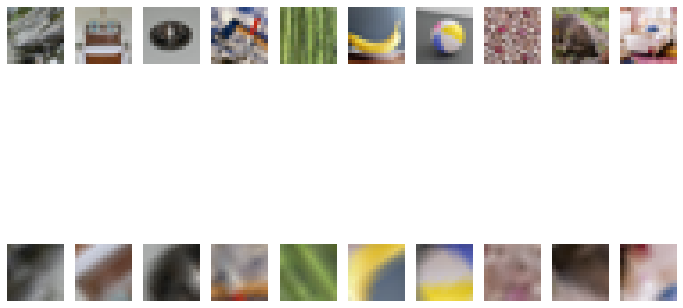

In [25]:
layer = 1
z_te_sim, z_tr_sim, t_te_sim, t_tr_sim, affine_weights, linear_weights, linear_bias = simulated_responses(x_te, x_tr, layer)

Stack:
1. Does network still learn if we slightly adjust activation functions from simulated data to training? -Test with larger ranges
1. Iterative Approach 
----------------------------------------------------------------------------
Try adding localisation network; affine layer parameters might incorrectly learn filter of feature map

Constraint: need to train lots of models, find ways to speed up / do in parallel / reuse modules

For later:
Combine filters from other layers too (try to recreate exact brain visual area RF perhaps)

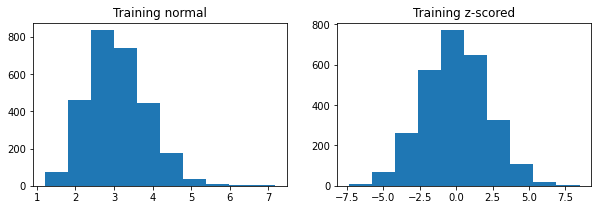

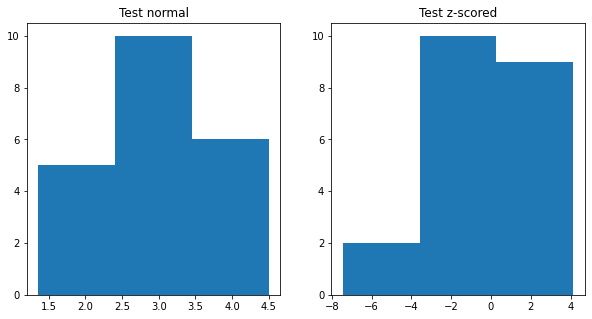

In [26]:
*plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title("Training normal")
plt.hist(t_tr_sim.asnumpy(), 10)
plt.subplot(1, 2, 2)
plt.title("Training z-scored")
plt.hist(z_tr_sim.asnumpy(), 10)
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Test normal")
plt.hist(t_te_sim.asnumpy(), 3)
plt.subplot(1, 2, 2)
plt.title("Test z-scored")
plt.hist(z_te_sim.asnumpy(), 3)
plt.show()

t_te_sim = z_te_sim
t_tr_sim = z_tr_sim

In [ ]:
def ftrain(prit=True, prit_init=True, plot=True):
    """Training loop, allows for various printing and plotting parameters"""
    batch_size = 6
    lr = 0.002
    wd = 0.000  # currently not logical to use because we can get loss of 0
    # batch norm, perhaps before linear layer

    def load_dataset(x, t, batch_size):
        return NDArrayIter({ "x": x }, { "t": t }, batch_size, True)

    train = load_dataset(nd.array(x_tr, ctx=ctx), t_tr_sim, batch_size)
    test =  load_dataset(nd.array(x_te, ctx=ctx), t_te_sim, batch_size)

    mse = gluon.loss.L2Loss()

    model = AFRT(layer)
    model.initialize(init=init.Zero(), force_reinit=True, ctx=ctx)
    trainer = gluon.Trainer(model.collect_params(), "Adam", {"learning_rate": lr, "clip_gradient": 1, "wd": wd})

    if prit or prit_init:
        param_list = list(model.collect_params().values())
        theta = param_list[0].data()[0].asnumpy()
        print("Initial theta: {}".format(theta))

    train_losses = []
    test_losses = []
    thetas = []

    start = time.time()
    n_epochs = 150

    for epoch in range(n_epochs):
        train.reset()
        test.reset()
        train_loss, test_loss = 0., 0.

        for batch in train:
            with autograd.record():
                y = model(batch.data[0])
                loss = mse(y, batch.label[0])
            loss.backward()
            trainer.step(batch_size)
            train_loss += loss.mean().asscalar()
            
        train_loss /= batch_size
        train_losses.append(train_loss)

        for batch in test:
            y = model(batch.data[0])
            loss = mse(y, batch.label[0])
            test_loss += loss.mean().asscalar()
        test_losses.append(test_loss)
        
        # Save parameters
        param_list = list(model.collect_params().values())
        theta = param_list[0].data()[0].asnumpy()
        thetas.append(theta)
        
        # Print intermediate results
        if prit and epoch % (n_epochs / 10) == 0:
            t = time.time() - start
            print("Epoch %i: Train loss: %.4f / Test loss: %.4f in %.0f seconds" % (epoch, train_loss, test_loss, t))
            print("Theta: {}".format(theta))

    print("Epoch %i: Train loss: %.4f / Test loss: %.4f in %.0f seconds" % (n_epochs, train_loss, test_loss, time.time() - start))
    thetas = np.array(thetas)
    if plot:
        plt.plot(train_losses, label="train")
        plt.plot(test_losses, label="test")
        plt.legend()
        plt.show()
        plt.plot(thetas[:,0])
        plt.hlines(affine_weights[0], 0, n_epochs, colors='darkblue')
        plt.title("Learned scale weight")
        plt.show()
        plt.title("Learned translation weights")
        plt.plot(thetas[:,2], label="x")
        plt.plot(thetas[:,3], label="y")
        plt.hlines(affine_weights[2], 0, n_epochs, colors='darkblue')
        plt.hlines(affine_weights[3], 0, n_epochs, colors='red')
        plt.legend()
        plt.show()
        plt.title("Learned rotation weights")
        plt.plot(thetas[:,1])
        plt.hlines(affine_weights[1], 0, n_epochs, colors='darkblue')
        plt.show()
    return train_losses, test_losses, thetas
    
train_losses, test_losses, thetas = ftrain()

/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:657: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  self.collect_params().initialize(init, ctx, verbose, force_reinit)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_chi

Initial theta: [0. 0. 0. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 


Epoch 0: Train loss: 185.5848 / Test loss: 10.4469 in 4 seconds
Theta: [-0.0527202   0.03073025  0.06028375  0.02052507]


-------------------1---------------------


/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:657: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  self.collect_params().initialize(init, ctx, verbose, force_reinit)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_chi

Epoch 150: Train loss: 159.6156 / Test loss: 17.6540 in 569 seconds


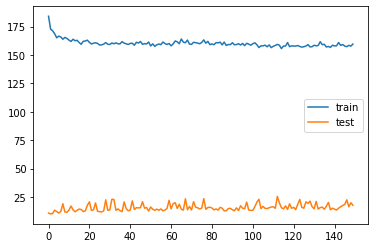

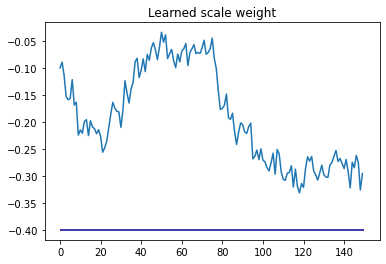

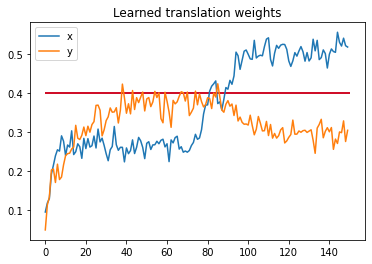

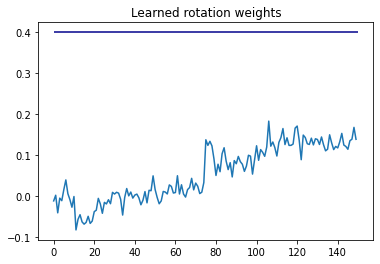

-------------------2---------------------


/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:657: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  self.collect_params().initialize(init, ctx, verbose, force_reinit)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_chi

Epoch 150: Train loss: 158.8097 / Test loss: 13.0139 in 588 seconds


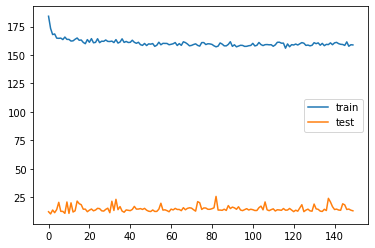

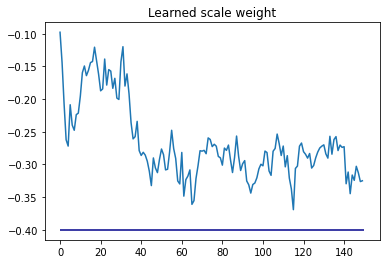

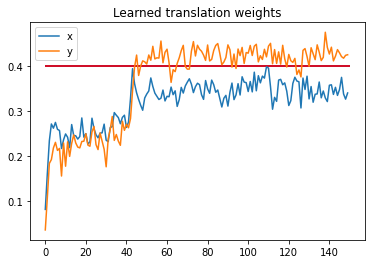

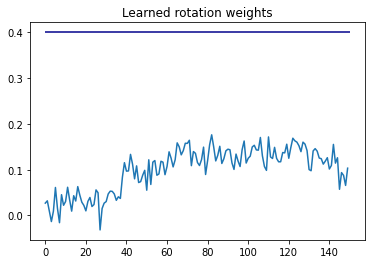

-------------------3---------------------


/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:657: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  self.collect_params().initialize(init, ctx, verbose, force_reinit)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_chi

Epoch 150: Train loss: 160.2607 / Test loss: 16.4993 in 611 seconds


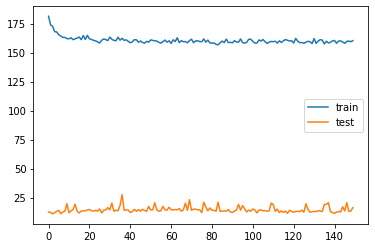

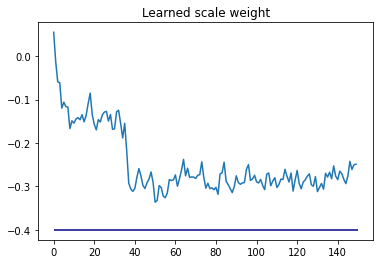

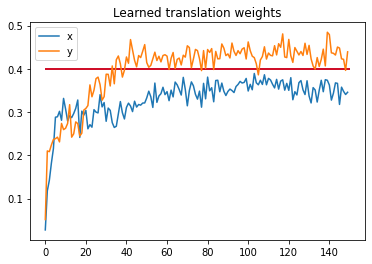

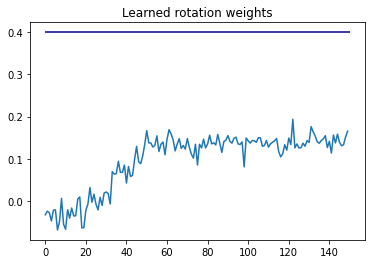

-------------------4---------------------


/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:657: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  self.collect_params().initialize(init, ctx, verbose, force_reinit)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_chi

Epoch 150: Train loss: 159.2575 / Test loss: 12.9739 in 596 seconds


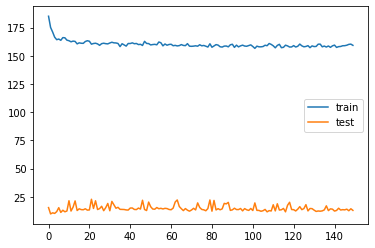

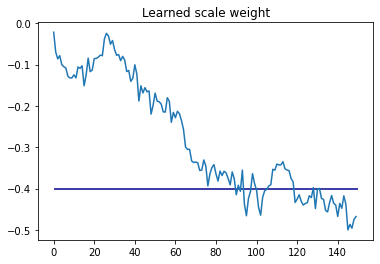

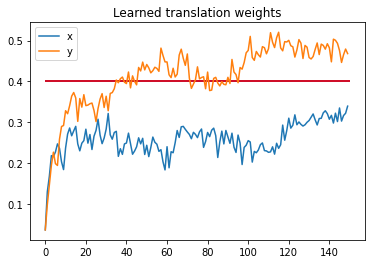

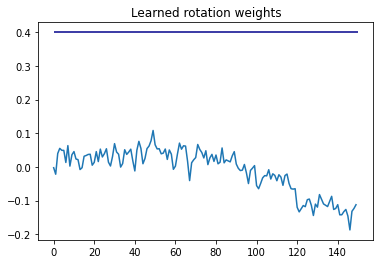

-------------------5---------------------


/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:657: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  self.collect_params().initialize(init, ctx, verbose, force_reinit)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_chi

Epoch 150: Train loss: 158.3954 / Test loss: 13.5760 in 604 seconds


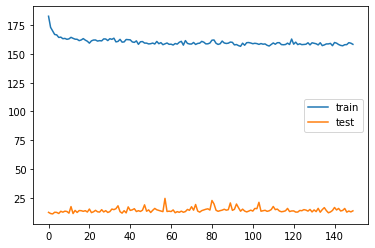

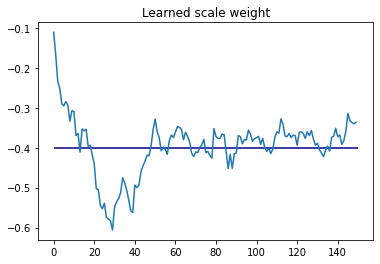

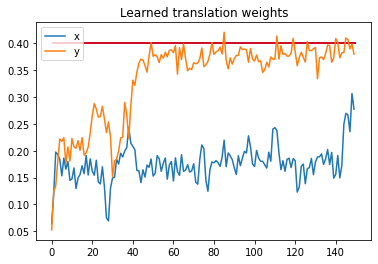

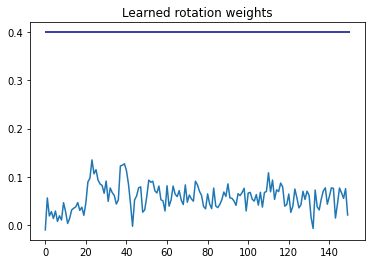

-------------------6---------------------


/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:657: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  self.collect_params().initialize(init, ctx, verbose, force_reinit)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_chi

Epoch 150: Train loss: 157.3438 / Test loss: 13.7414 in 601 seconds


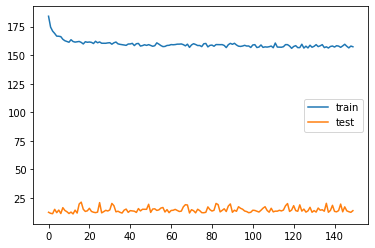

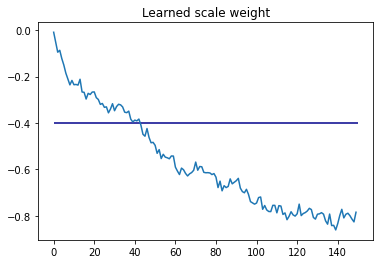

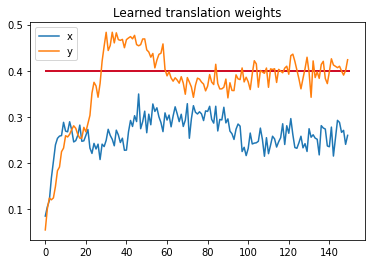

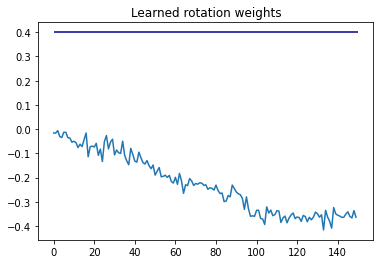

-------------------7---------------------


/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:657: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  self.collect_params().initialize(init, ctx, verbose, force_reinit)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_chi

Epoch 150: Train loss: 158.5892 / Test loss: 12.7004 in 614 seconds


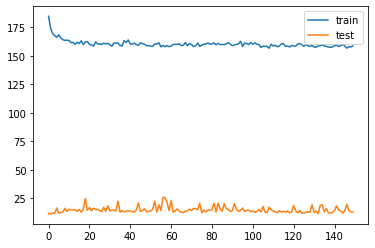

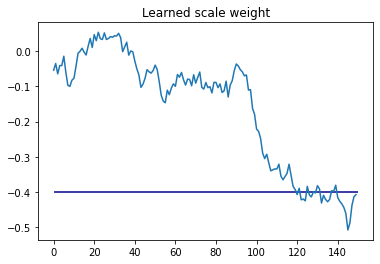

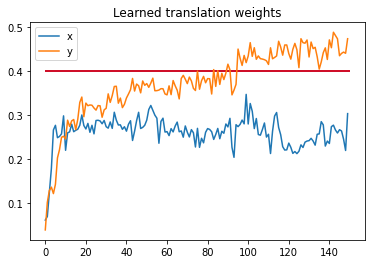

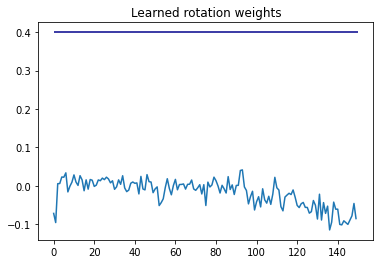

-------------------8---------------------


/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:657: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  self.collect_params().initialize(init, ctx, verbose, force_reinit)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_chi

Epoch 150: Train loss: 157.8210 / Test loss: 12.7426 in 594 seconds


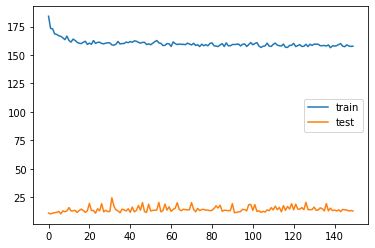

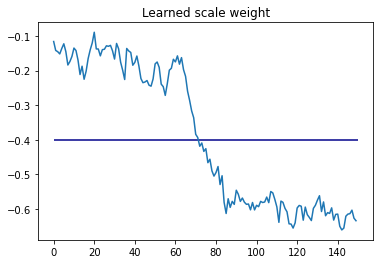

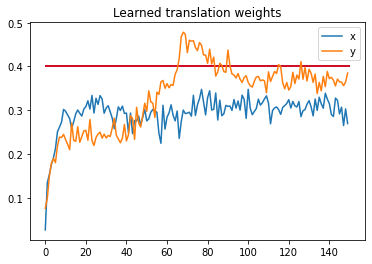

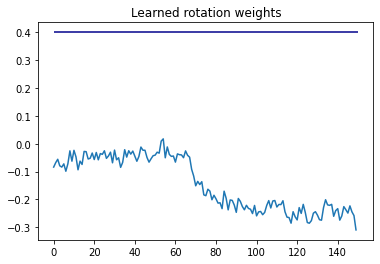

-------------------9---------------------


/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:657: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  self.collect_params().initialize(init, ctx, verbose, force_reinit)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_chi

Epoch 150: Train loss: 159.2742 / Test loss: 14.5650 in 621 seconds


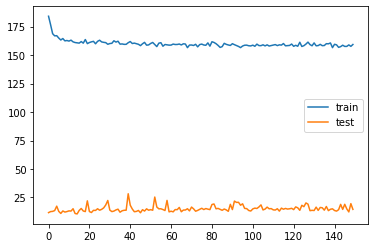

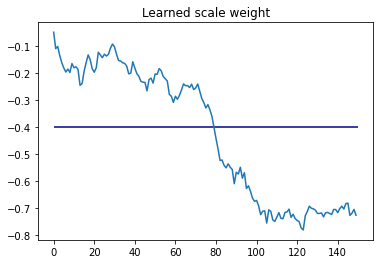

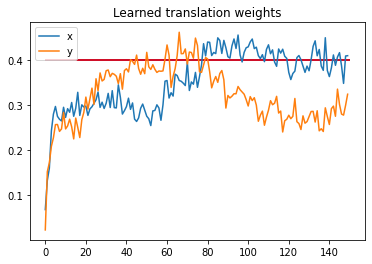

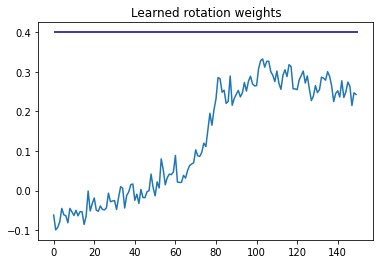

-------------------10---------------------


/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:657: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  self.collect_params().initialize(init, ctx, verbose, force_reinit)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: "AFRT._feature" is an unregistered container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_chi

Epoch 150: Train loss: 159.8502 / Test loss: 14.7280 in 642 seconds


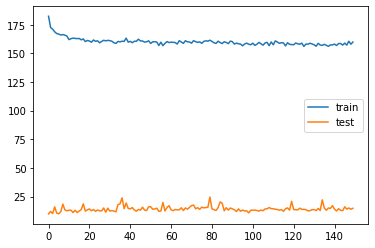

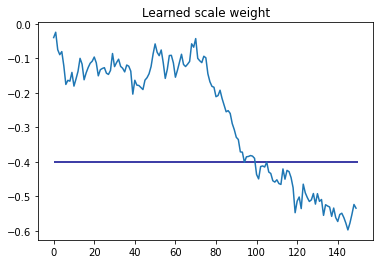

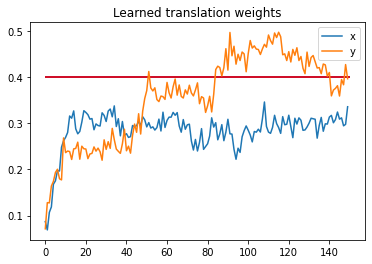

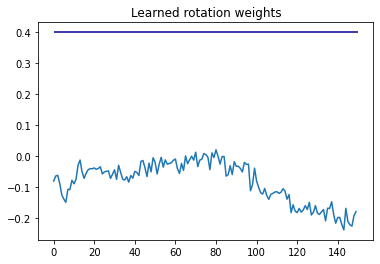

0


In [30]:
def learned(x, y):
    alpha = 0.05
    return all(x[-1] < y + alpha) and all(x[-1] > y - alpha)

def train_repeat(rep=10, plot=True):
    correct = 0
    for i in range(rep):
        print("-------------------{}---------------------".format(i + 1))
        
        train_loss, test_loss, thetas = ftrain(prit=False, prit_init=False, plot=plot)  
        if learned(thetas, affine_weights):
            correct += 1
    return correct

correct = train_repeat()
print(correct)

# Testing

In [19]:
scaleses = [0.0, 0.2, 0.4]
transes = [0.0, 0.0, 0.2]
data = np.zeros((len(scaleses), len(transes)))
for i, scale in enumerate(scaleses):
    for j, trans in enumerate(transes):
        a_weights = np.array([scale, 0, trans, 0, scale, trans])
        _, _, t_te_sim, t_tr_sim, affine_weights, linear_weights, linear_bias = simulated_responses(x_te, x_tr, layer, a_weights, plot=False)
        correct = train_repeat(5, plot=False)
        print(correct)
        data[len(scaleses) - 1 - i, j] = correct

plt.imshow(data / 5, cmap='RdYlGn')
plt.xlabel('translation')
plt.ylabel('scale')
plt.xticks(range(len(transes)), transes)
plt.yticks(range(len(scaleses)), np.flip(scaleses))
plt.show()

ValueError: ignored

In [ ]:
# 5, 4, 1, 5, 5, 3, 3, 3, 1
# 0.0 - 0.0 = 5
# 0.0 - 0.2 = 4
# 0.0 - 0.4 = 1
# 0.2 - 0.4 = 3
# 0.4 - 0.4 = 1
tr = [5, 4, 1, 5, 5, 3, 3, 3, 1]
counter = 0
scaleses = [0, 0.2, 0.4]
transes = [0, 0.2, 0.4]
data = np.zeros((len(scaleses), len(transes)))
for i, scale in enumerate(scaleses):
    for j, trans in enumerate(transes):
        a_weights = np.array([scale, 0, trans, 0, scale, trans])
        data[len(scaleses) - 1 - i, j] = tr[counter]
        counter += 1
plt.imshow(data / 5, cmap='RdYlGn')
plt.xlabel('translation')
plt.ylabel('scale')
plt.xticks(range(len(transes)), transes)
plt.yticks(range(len(scaleses)), np.flip(scaleses))
plt.show()

In [ ]:
# Test model
test = load_dataset(nd.array(x_te, ctx=ctx), t_te_sim, batch_size=3)
for batch in test:
    pred = model(batch.data[0])
    print("Pearson R:", sst.pearsonr(pred.asnumpy()[:,0], t_te_sim.asnumpy()[:,0]))
# Pearson r on model prediction and true target

# Retinotopic map:

# Visualization of x_te with new affine parameters
# Get learned parameters:
name = [elem.name for elem in model.collect_params().values()]
sc = model.collect_params()[name[0]].data()[0]
tr = model.collect_params()[name[1]].data()[0]
print(sc.asnumpy(), tr.asnumpy())

# Create Affine layer with new weights
fov = [16, 32, 32, 32, 64, 224, 224, 224]
learned = AffineSimple(fov[layer-1])
learned.initialize(ctx=ctx)
name = [elem.name for elem in learned.params.values()]
learned.params[name[0]].data()[0] = sc
learned.params[name[1]].data()[0] = tr

# Compare to Affine layer with original weights
true = AffineSimple(fov[layer-1])
true.initialize(ctx=ctx)
name = [elem.name for elem in true.params.values()]
true.params[name[0]].data()[0] = affine_weights[0]
true.params[name[1]].data()[0] = [affine_weights[2], affine_weights[5]]

unreg_xte = visualize(x_te, te_means, te_stds)
unreg_learned = learned(nd.array(unreg_xte, ctx=ctx))
unreg_true = true(nd.array(unreg_xte, ctx=ctx))

for i in range(len(x_te)):
    # data type should be uint8, shape should be (size, size, 3)
    img = np.transpose(unreg_xte[i], (1, 2, 0))
    learned_image = np.uint8(np.transpose(unreg_learned[i].asnumpy(), (1, 2, 0)))
    true_image = np.uint8(np.transpose(unreg_true[i].asnumpy(), (1, 2, 0)))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(Image.fromarray(img))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(Image.fromarray(learned_image))
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(Image.fromarray(true_image))
    plt.axis('off')
    plt.show()